In [22]:
import rasterio
import os
from rasterio.plot import show
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import json

gdal.UseExceptions()

In [44]:
new_orleans_bund = gpd.read_file('data/new_orleans.geojson')

In [23]:
fc_2023 = rasterio.open('data/fc_2023.tif')
fc_2013 = rasterio.open('data/fc_2013.tif')

In [24]:


# Function to normalize the grid values
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))


def preprocess_img(img):
    red = img.read(1)
    green = img.read(2)
    blue = img.read(3)

    # Normalize the bands
    redn = normalize(red)
    greenn = normalize(green)
    bluen = normalize(blue)
    return np.dstack((redn, greenn, bluen))


(-0.5, 7540.5, 7690.5, -0.5)

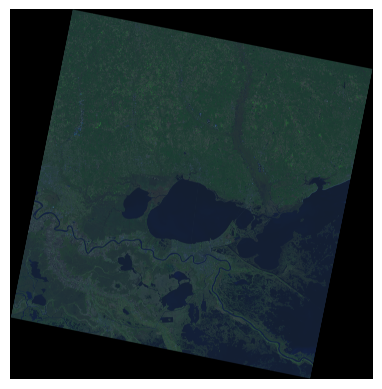

In [25]:
# Create RGB natural color composite
rgb13 = preprocess_img(fc_2013)

# Let's see how our color composite looks like
plt.imshow(rgb13)

# set axis off
plt.axis('off')

(-0.5, 7530.5, 7690.5, -0.5)

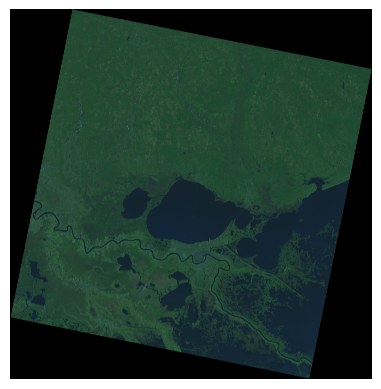

In [26]:
# Create RGB natural color composite
rgb = preprocess_img(fc_2023)

# Let's see how our color composite looks like
plt.imshow(rgb)

# set axis off
plt.axis('off')

In [27]:
r23_dir = '/Users/marioag/Downloads/LC08_L1TP_022039_20231128_20231208_02_T1/'
r13_dir = '/Users/marioag/Downloads/LC08_L1TP_022039_20131218_20200912_02_T1/'


In [28]:
def calc_ndvi(red, nir):
    """Calculate NDVI from integer arrays"""
    # if nir + red == 0:
    #     ndvi = 0
    # else:
    ndvi = (nir.astype(float) - red.astype(float)) / (nir + red)
    return ndvi

/var/folders/g5/b592wl6x12s0tx4jfw9f7_j40000gn/T/ipykernel_19893/3372704716.py:6: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir.astype(float) - red.astype(float)) / (nir + red)


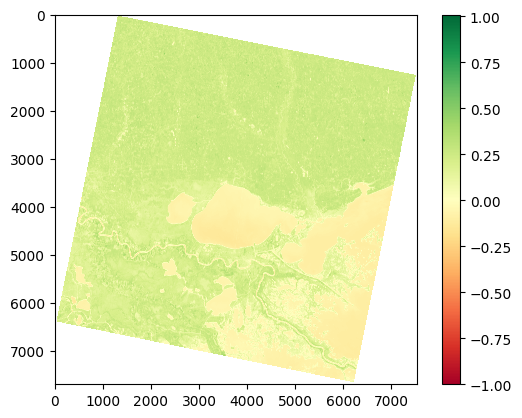

In [29]:
nir_23 = rasterio.open(os.path.join(r23_dir, 'LC08_L1TP_022039_20231128_20231208_02_T1_B5.TIF'))
red_23 = rasterio.open(os.path.join(r23_dir, 'LC08_L1TP_022039_20231128_20231208_02_T1_B4.TIF'))

nir_23 = nir_23.read(1)
red_23 = red_23.read(1)

ndvi_23 = calc_ndvi(red_23, nir_23)

# Plot our NDVI figure
plt.imshow(ndvi_23, cmap='RdYlGn')
plt.colorbar()

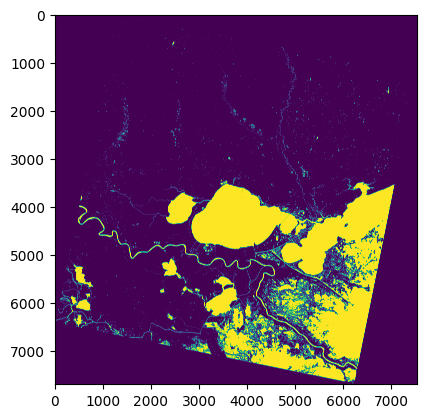

In [30]:
# plot where ndvi == < 0 indicating water
plt.imshow(ndvi_23 < 0 )

/var/folders/g5/b592wl6x12s0tx4jfw9f7_j40000gn/T/ipykernel_19893/3372704716.py:6: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir.astype(float) - red.astype(float)) / (nir + red)


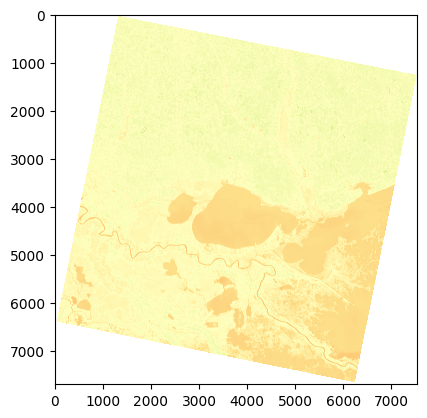

In [31]:
# get ndvi for 2013 image
nir_13 = rasterio.open(os.path.join(r13_dir, 'LC08_L1TP_022039_20131218_20200912_02_T1_B5.TIF'))
red_13 = rasterio.open(os.path.join(r13_dir, 'LC08_L1TP_022039_20131218_20200912_02_T1_B4.TIF'))

nir_13 = nir_13.read(1)
red_13 = red_13.read(1)

ndvi_13 = calc_ndvi(red_13, nir_13)

# Plot our NDVI figure
plt.imshow(ndvi_13, cmap='RdYlGn')

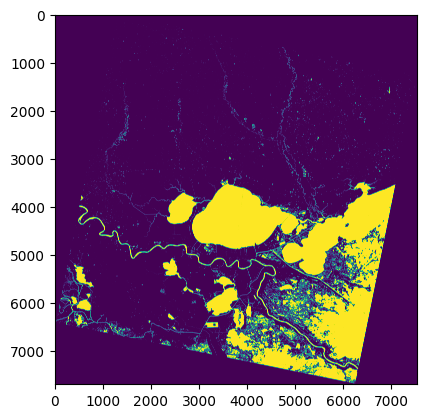

In [32]:
# plot where ndvi == < 0 indicating water
plt.imshow(ndvi_13 < 0 )

In [33]:
# water mask
water_23 = np.where(ndvi_23 < 0, 1, 0)
water_13 = np.where(ndvi_13 < 0, 1, 0)

In [34]:
water_23 = water_23.astype(int)
water_13 = water_13.astype(int)

In [35]:
# diff = water_23 - water_13
# set shapes to be equal to 7691, 7531, adding na values to the end of the array
water_23 = np.pad(water_23, ((0, 0), (0, 10)), 'constant', constant_values=(0, 0))

In [36]:
diff = water_13 - water_23

<Figure size 1000x1000 with 0 Axes>

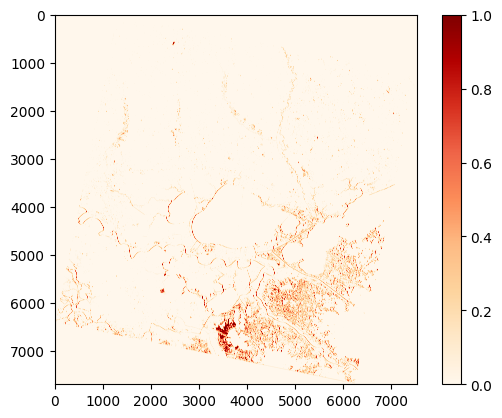

<Figure size 1000x1000 with 0 Axes>

In [37]:
plt.imshow(diff<0, cmap='OrRd')
plt.colorbar()

# set figsize
plt.figure(figsize=(10, 10))

In [38]:
diff = diff.astype(float)

In [46]:
# clip new orleans bund to the water mask
new_orleans_bund = new_orleans_bund.to_crs('EPSG:32615')


<Axes: >

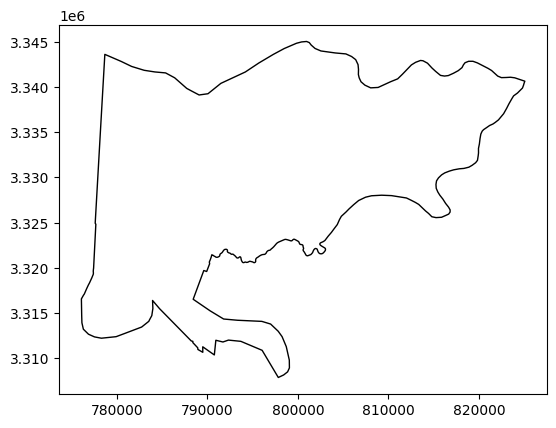

In [50]:
new_orleans_bund.boundary.plot( color='black', edgecolor='black', linewidth=1)


<Figure size 1000x1000 with 0 Axes>

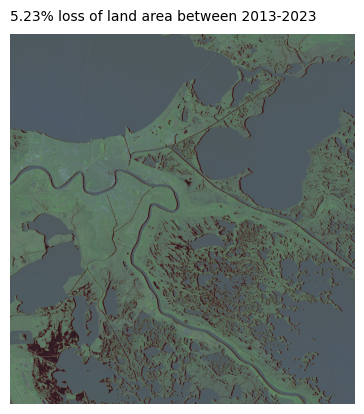

<Figure size 1000x1000 with 0 Axes>

In [54]:
# superimpose lost water on top of 2023 image
# superimpose new orleans boundary


# set bbox to only cover new orleans
plt.xlim(3200, 6000)
plt.ylim(7000, 4000)

# do not show 0 value pixels in diff
diff[diff == 0] = np.nan
plt.imshow(diff<0, cmap='OrRd')
plt.imshow(rgb, alpha=0.75)
new_orleans_bund.boundary.plot(ax=plt.gca(), color='black', edgecolor='black', linewidth=1)

# calculate area of changed pixels
# copy diff to bounds of plt limits
diff_copy = np.copy(diff)
# crop diff by plt limits
diff_copy = diff_copy[3200:6000, 4000:7000]

# calculate area of changed pixels
area_dc = np.count_nonzero(diff_copy<0)
# print(area, area_dc)
# get the area in bounds
total_area_plot = diff_copy.shape[0] * diff_copy.shape[1]

# calculate percent change
percent_change = area_dc / total_area_plot * 100

# annotate chart with percent change
# place title at bottom of image

plt.title('{:.2f}% loss of land area between 2013-2023'.format(percent_change), fontsize=10, loc='left', pad=10)

# set axis off
plt.axis('off')

# set figsize
plt.figure(figsize=(10, 10))



5.23% loss of land area between 2013-2023


(3200.0, 6000.0, 7000.0, 4000.0)

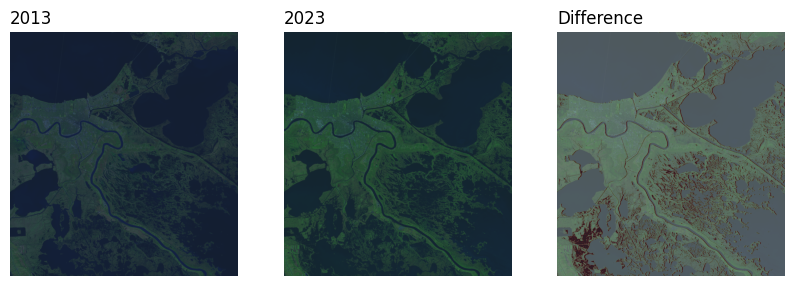

In [56]:
# plot triptych of 2013, 2023, and difference
fig, axs = plt.subplots(1, 3, figsize=(10, 30))

print('{:.2f}% loss of land area between 2013-2023'.format(percent_change)) 


plt.subplot(1, 3, 1)
plt.xlim(3200, 6000)
plt.ylim(7000, 4000)
plt.imshow(rgb13, cmap='RdYlGn')
plt.title('2013', loc='left')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.xlim(3200, 6000)
plt.ylim(7000, 4000)
plt.imshow(rgb, cmap='RdYlGn')
plt.title('2023', loc='left')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.xlim(3200, 6000)
plt.ylim(7000, 4000)
plt.imshow(diff<0, cmap='OrRd')
plt.imshow(rgb, alpha=0.75)
plt.title('Difference', loc='left')
plt.axis('off')
